In [1]:
import sys
sys.path.append("/Volumes/work/phd/‌MoLFormer_fMRI")

In [2]:
import pandas as pd
from utils.helpers import *
from scipy.stats import pearsonr,spearmanr
#cosine similarity
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import nilearn
from scipy import stats
from utils import CKA


In [3]:
base_dir = '../../../../T5 EVO'


In [4]:


def cosine_similarity_matrix(df):
    """
    Compute the cosine similarity between each pair of row in df
    """
    #compute the cosine similarity between each pair of row in df
    cosine_similarity_1= cosine_similarity(df)
    #keep only the upper triangle of the matrix
    cosine_similarity_2 = np.triu(cosine_similarity_1, k=1)
    cosine_similarity_2 = cosine_similarity_2[np.triu_indices_from(cosine_similarity_2, k=1)]
    return cosine_similarity_1, cosine_similarity_2


sssss (160, 101)
Subject 1, ROI PirF, Model ChemBERT_ChEMBL_pretrained, Layer 8: 0.013705500541270342 -0.0001838826180780455 0.012359855490236304 -4.444885379330955e-05
Subject 1, ROI PirF, Model ChemBERTa-zinc-base-v1, Layer 6: 0.008908432564964677 -6.655236882206784e-05 0.0072221566249569815 -5.8956993204718586e-05
Subject 1, ROI PirF, Model MoLFormer-XL-both-10pct, Layer 12: 0.027270818850537743 0.00022184640745618716 0.021289328837599653 0.00039698806563988364
Subject 1, ROI PirF, Model SELFormer, Layer 12: 0.011226533496548582 0.00020056585325158106 0.006793812271787549 0.0001330249945487586
Subject 1, ROI PirF, Model openpom, Layer 1000: 0.04076392160788692 -0.0003732471225210562 0.0377026239569875 -0.0004069739814309824
Subject 1, ROI PirF, Model behavior, Layer 1000: 0.08342850293295356 -0.0004878932618527527 0.07844641370822847 -0.000518614640542493
sssss (160, 142)
Subject 1, ROI PirT, Model ChemBERT_ChEMBL_pretrained, Layer 8: 0.01774943034039767 7.731063918805412e-05 0.0169

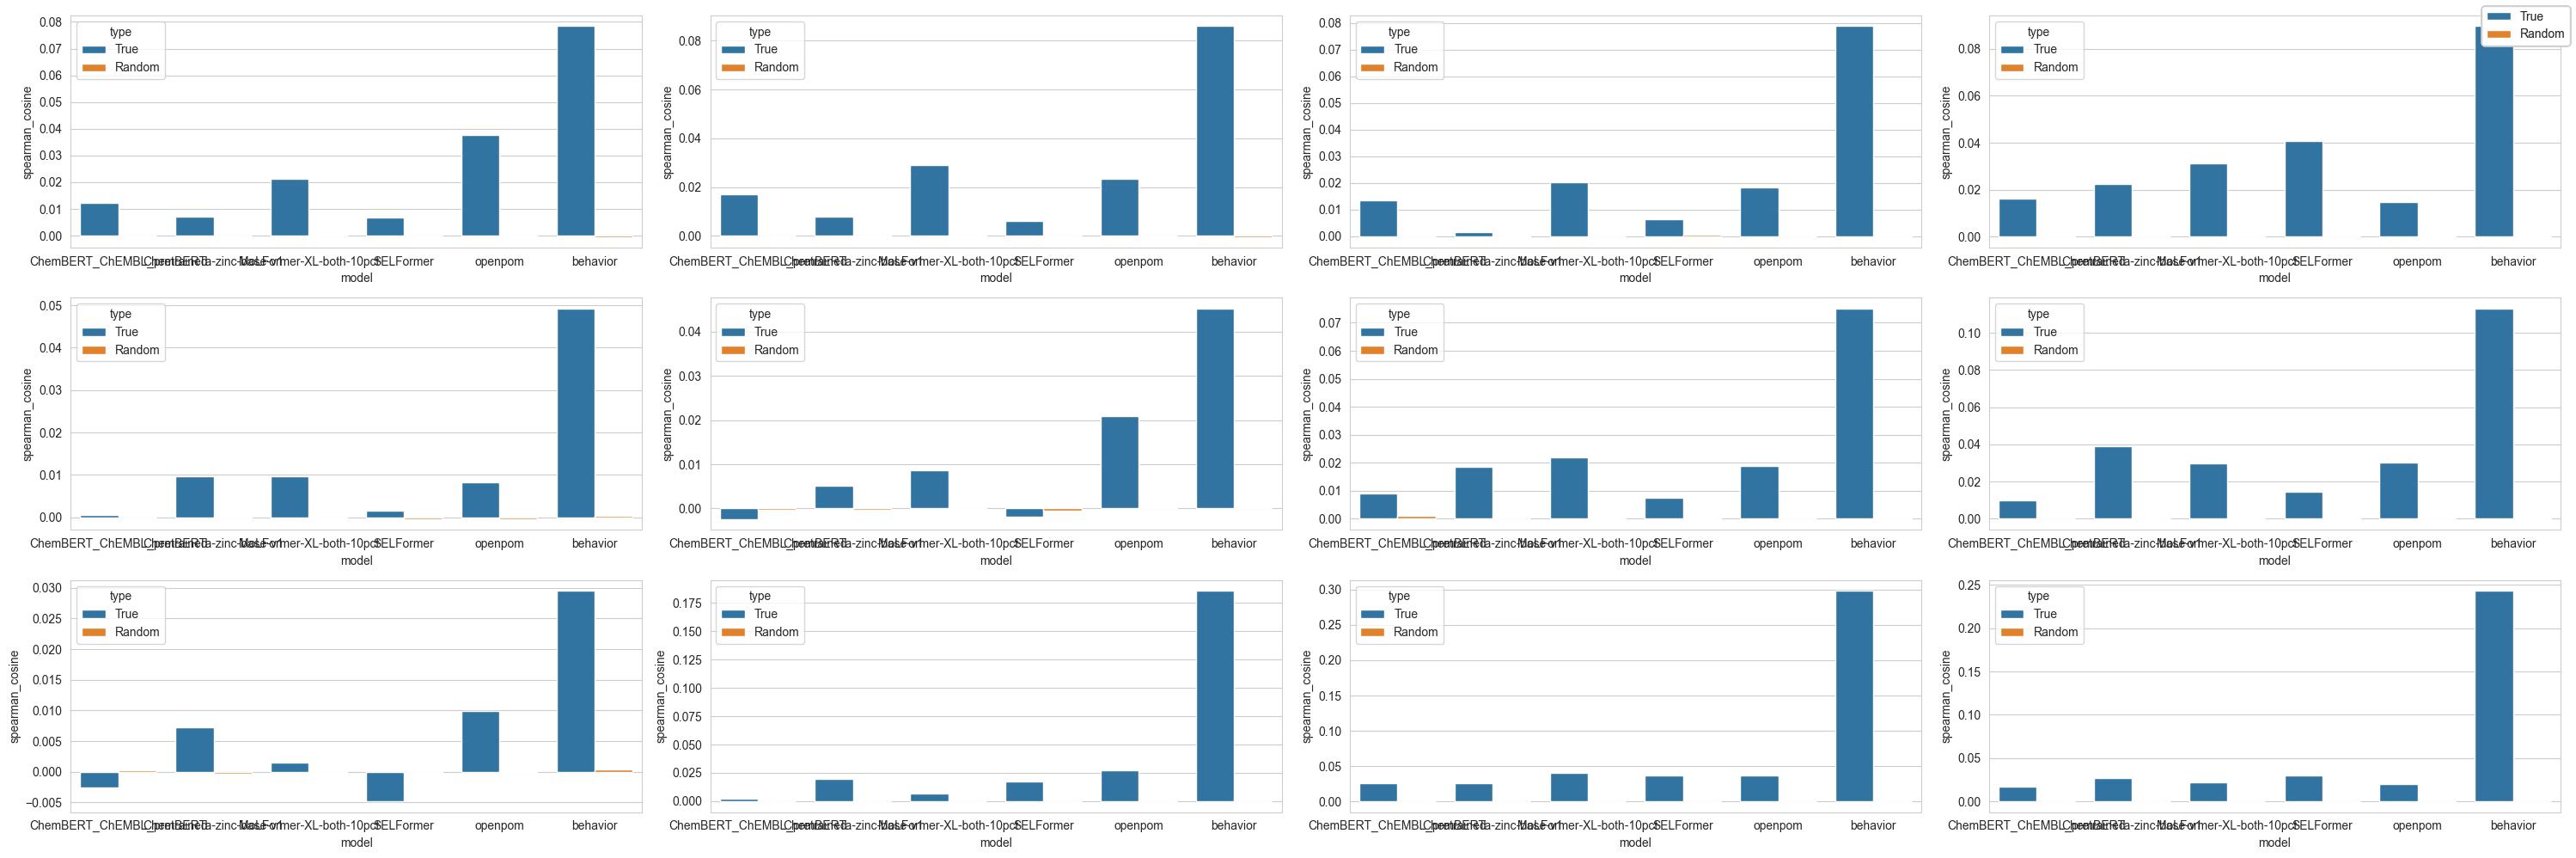

1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


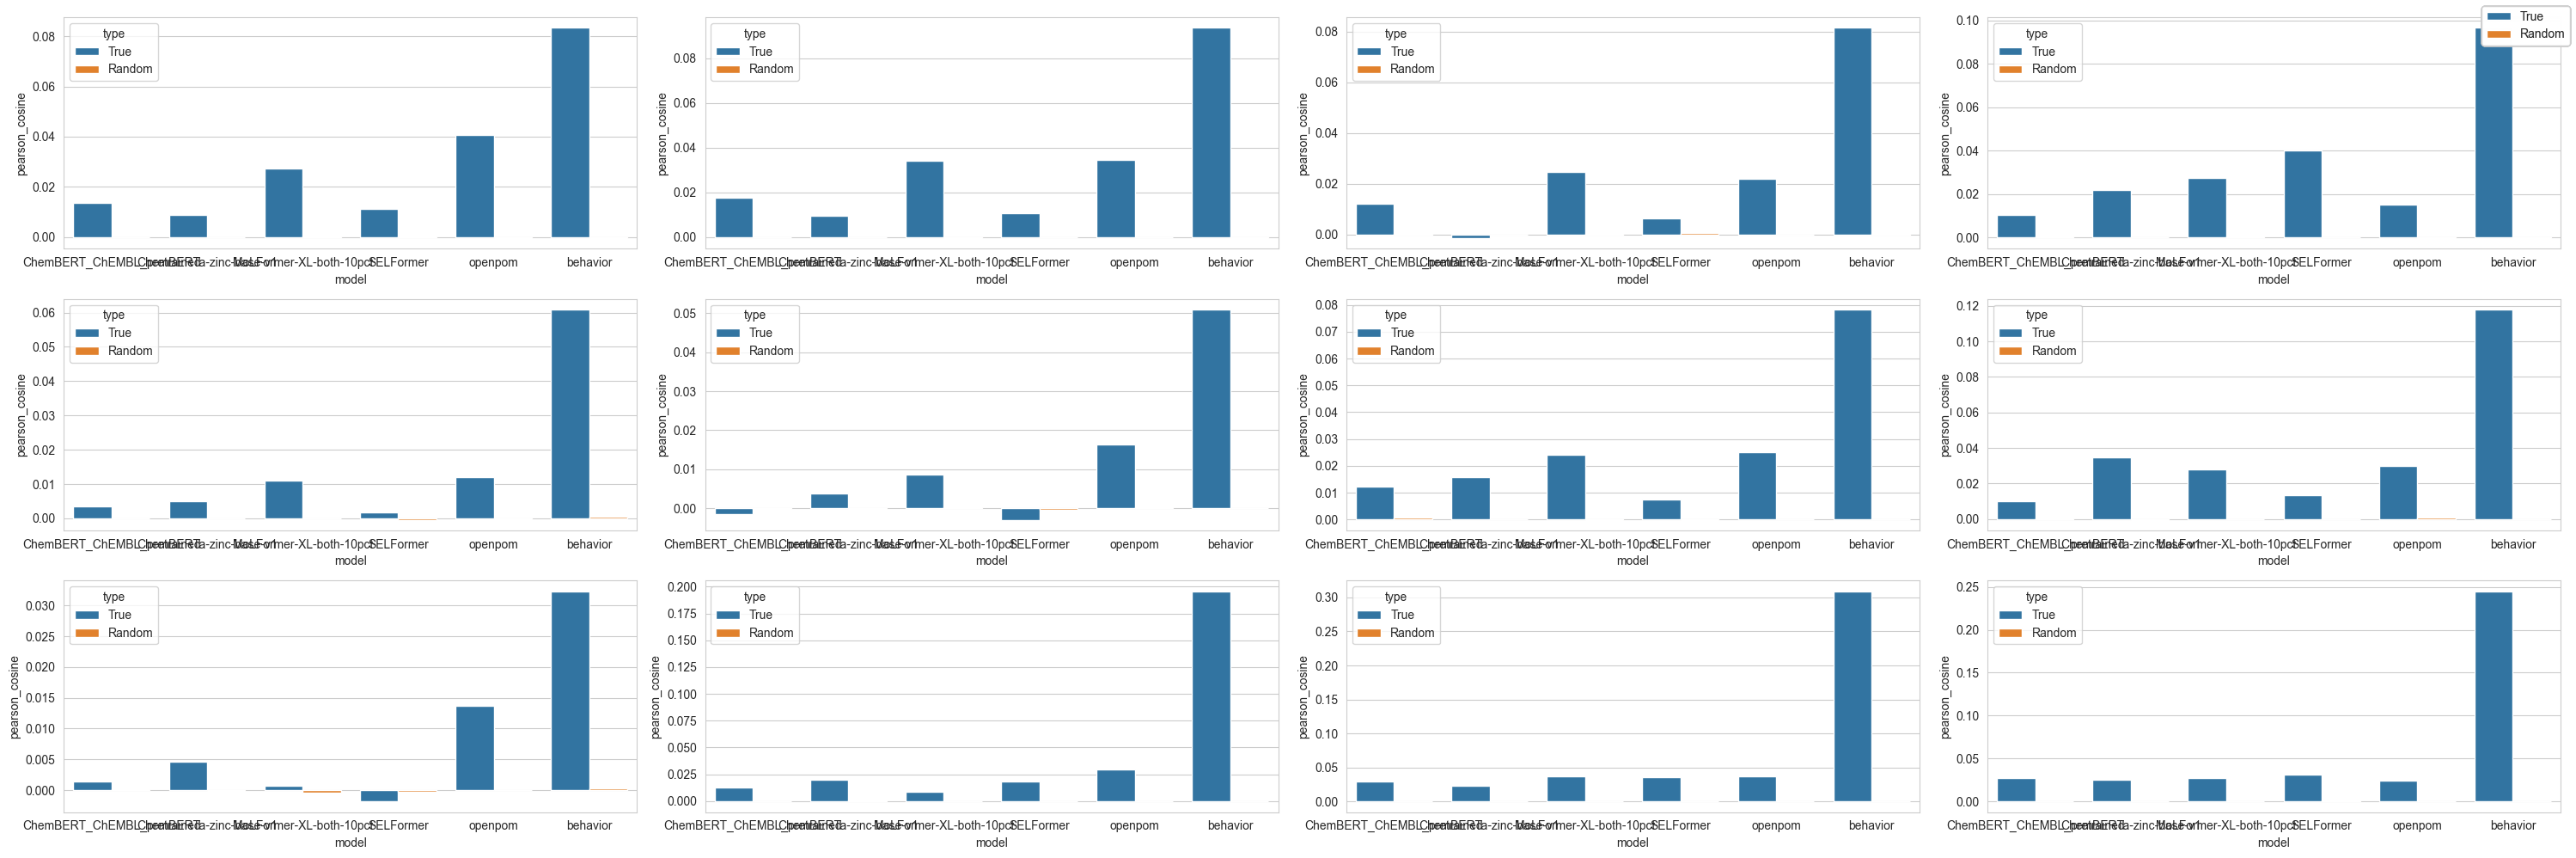

In [8]:
layers = [9,7,13,13,1001,1001]
models = ['ChemBERT_ChEMBL_pretrained', 'ChemBERTa-zinc-base-v1','MoLFormer-XL-both-10pct','SELFormer', 'openpom', 'behavior']

orgi_avg= True

corrs_true=pd.DataFrame()
corrs_random=pd.DataFrame()

for subject in range(1,4):
    for roi in ["PirF","PirT","AMY","OFC"]:

        if orgi_avg:
            masked_fmri=read_orig_avg(base_dir, subject, roi)
            save_path = f"{base_dir}/fmri/fmri_orig/"
        else:

            parent_input_sagar_original = f'{base_dir}/fmri/average_of_singletrial/fmri_{subject}_{roi}.csv'
            df = pd.read_csv(parent_input_sagar_original)
            fmri_array =df_to_cid_voxel_array(df)
            nc_mask =create_nc_mask( base_dir,subject,roi)
            _,masked_fmri =mask_fmri(base_dir,fmri_array,nc_mask,subject,roi)
            save_path = f"{base_dir}/fmri/average_of_singletrial/"
        masked_fmri = stats.zscore(masked_fmri)





        path_ROI = f'../../../../T5 EVO/fmri/supportings/S{subject}/'
        _,cosine_similarity_fmri = cosine_similarity_matrix(masked_fmri)
        # c=CKA.linear_CKA(masked_fmri,masked_fmri)
        # print(c,"sss")
        # _,cka_fmri = CKA.up_triangle()

        for m,model in enumerate(models) :
            layer= layers[m]-1
            embeddings = np.load(f'../results/embeddings_{model}_{subject}_{layer}.npy')
            embeddings = stats.zscore(embeddings, axis=0)
            _,cosine_similarity_embeddings = cosine_similarity_matrix(embeddings)
            # _,cka_embeddings = CKA.up_triangle(CKA.linear_CKA(embeddings,embeddings))
            pearsoncorr_coef1, _ = pearsonr(cosine_similarity_fmri.flatten(), cosine_similarity_embeddings.flatten())
            spearmancorr_coef1, _ = spearmanr(cosine_similarity_fmri.flatten(), cosine_similarity_embeddings.flatten())

            # pearsoncorr_coef1_cka, _ = pearsonr(cka_fmri.flatten(), cka_embeddings.flatten())
            # spearmancorr_coef1_cka, _ = spearmanr(cka_fmri.flatten(), cka_embeddings.flatten())

            pearsoncorr_coefs_random=[]
            spearmancorr_coefs_random=[]


            pearsoncorr_coefs2_cka=[]
            spearmancorr_coefs2_cka=[]

            for i in range(1000):
                np.random.shuffle(embeddings)
                _,cosine_similarity_random_embeddings = cosine_similarity_matrix(embeddings)
                # _,cka_random_embeddings = cosine_similarity_matrix(cka_embeddings)
                pearsoncorr_coef_random, _ = pearsonr(cosine_similarity_fmri.flatten(), cosine_similarity_random_embeddings.flatten())
                spearmancorr_coef_random, _ = spearmanr(cosine_similarity_fmri.flatten(), cosine_similarity_random_embeddings.flatten())

                # pearsoncorr_coef_random_cka, _ = pearsonr(cka_fmri.flatten(), cka_random_embeddings.flatten())
                # spearmancorr_coef2_cka, _ = spearmanr(cka_fmri.flatten(), cka_random_embeddings.flatten())


                pearsoncorr_coefs_random.append(pearsoncorr_coef_random)
                spearmancorr_coefs_random.append(spearmancorr_coef_random)

                # pearsoncorr_coefs2_cka.append(pearsoncorr_coef2_cka)
                # spearmancorr_coefs2_cka.append(spearmancorr_coef2_cka)
                # p_values2.append(p_value2)

            pearson_coef_random=np.mean(pearsoncorr_coefs_random)
            spearman_coef_random=np.mean(spearmancorr_coefs_random)

            # pearson_coef2_cka=np.mean(pearsoncorr_coefs2)
            # spearman_coef2_cka=np.mean(spearmancorr_coefs2)

            #compute the correlation between the cosine similarity of the fmri and the embeddings

            print(f"Subject {subject}, ROI {roi}, Model {model}, Layer {layer}:" ,pearsoncorr_coef1,pearson_coef_random,spearmancorr_coef1,spearman_coef_random)
            # print(f"Correlation Coefficient: {corr_coef1}, {corr_coef2}")



            corrs = pd.DataFrame([pearsoncorr_coef1],columns=['pearson_cosine'])
            corrs['spearman_cosine']= spearmancorr_coef1
            # corrs['spearman_cka']= spearmancorr_coef1_cka
            # corrs['pearson_cka']= pearsoncorr_coef1_cka
            corrs['model'] = model
            corrs['subject'] = subject
            corrs['roi'] = roi
            corrs['layer'] =layer
            corrs['type']= 'True'

            corrs_true = pd.concat((corrs_true,corrs))


            corrs = pd.DataFrame([pearson_coef_random],columns=['pearson_cosine'])
            corrs['spearman_cosine']= spearman_coef_random
            # corrs['spearman_cka']= spearman_coef2_cka
            # corrs['pearson_cka']= pearson_coef2_cka
            corrs['model'] = model
            corrs['subject'] = subject
            corrs['roi'] = roi
            corrs['layer'] =layer
            corrs['type']= 'Random'
            corrs['spearman']= spearman_coef_random
            corrs_true = pd.concat((corrs_true,corrs))


corrs_true.to_csv(f'{save_path}/allVoxels_RSA.csv',index=False)


1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


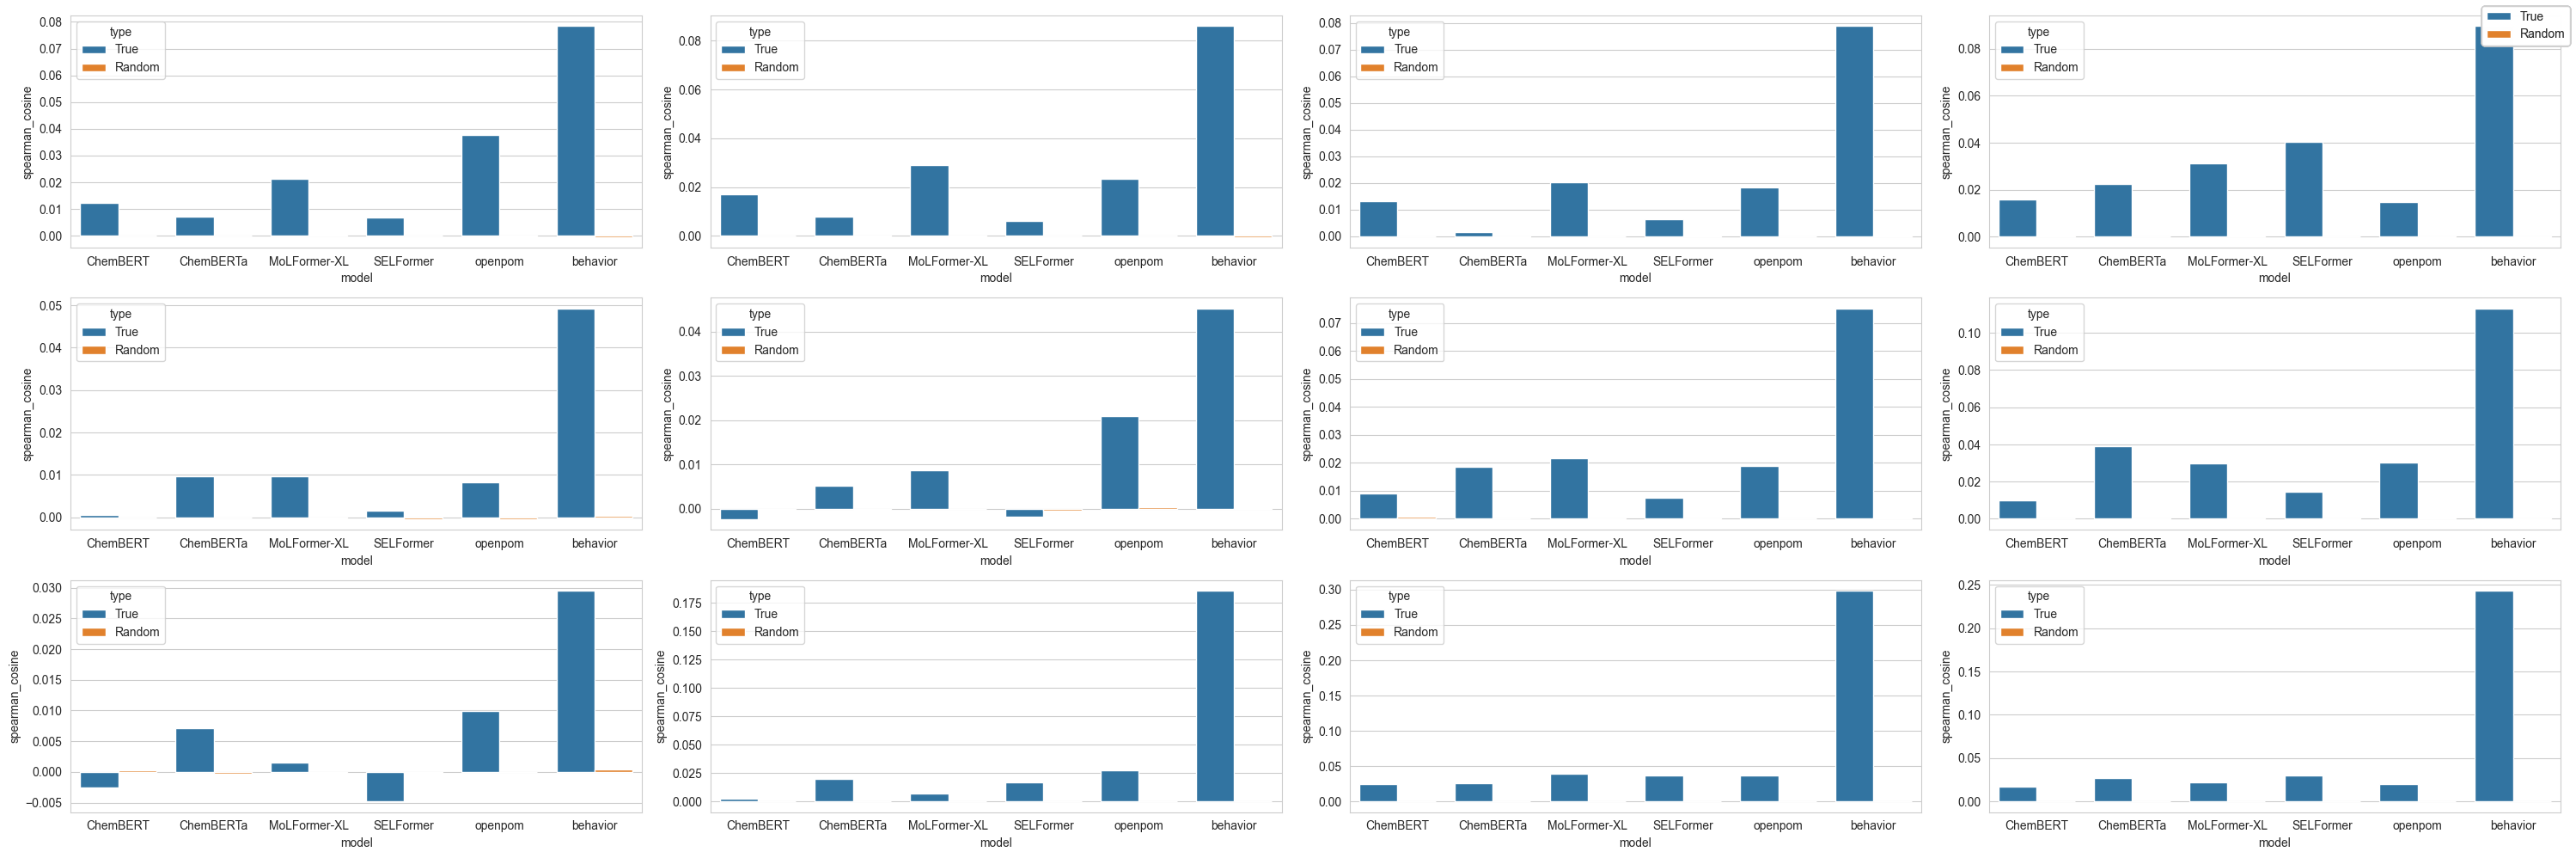

1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


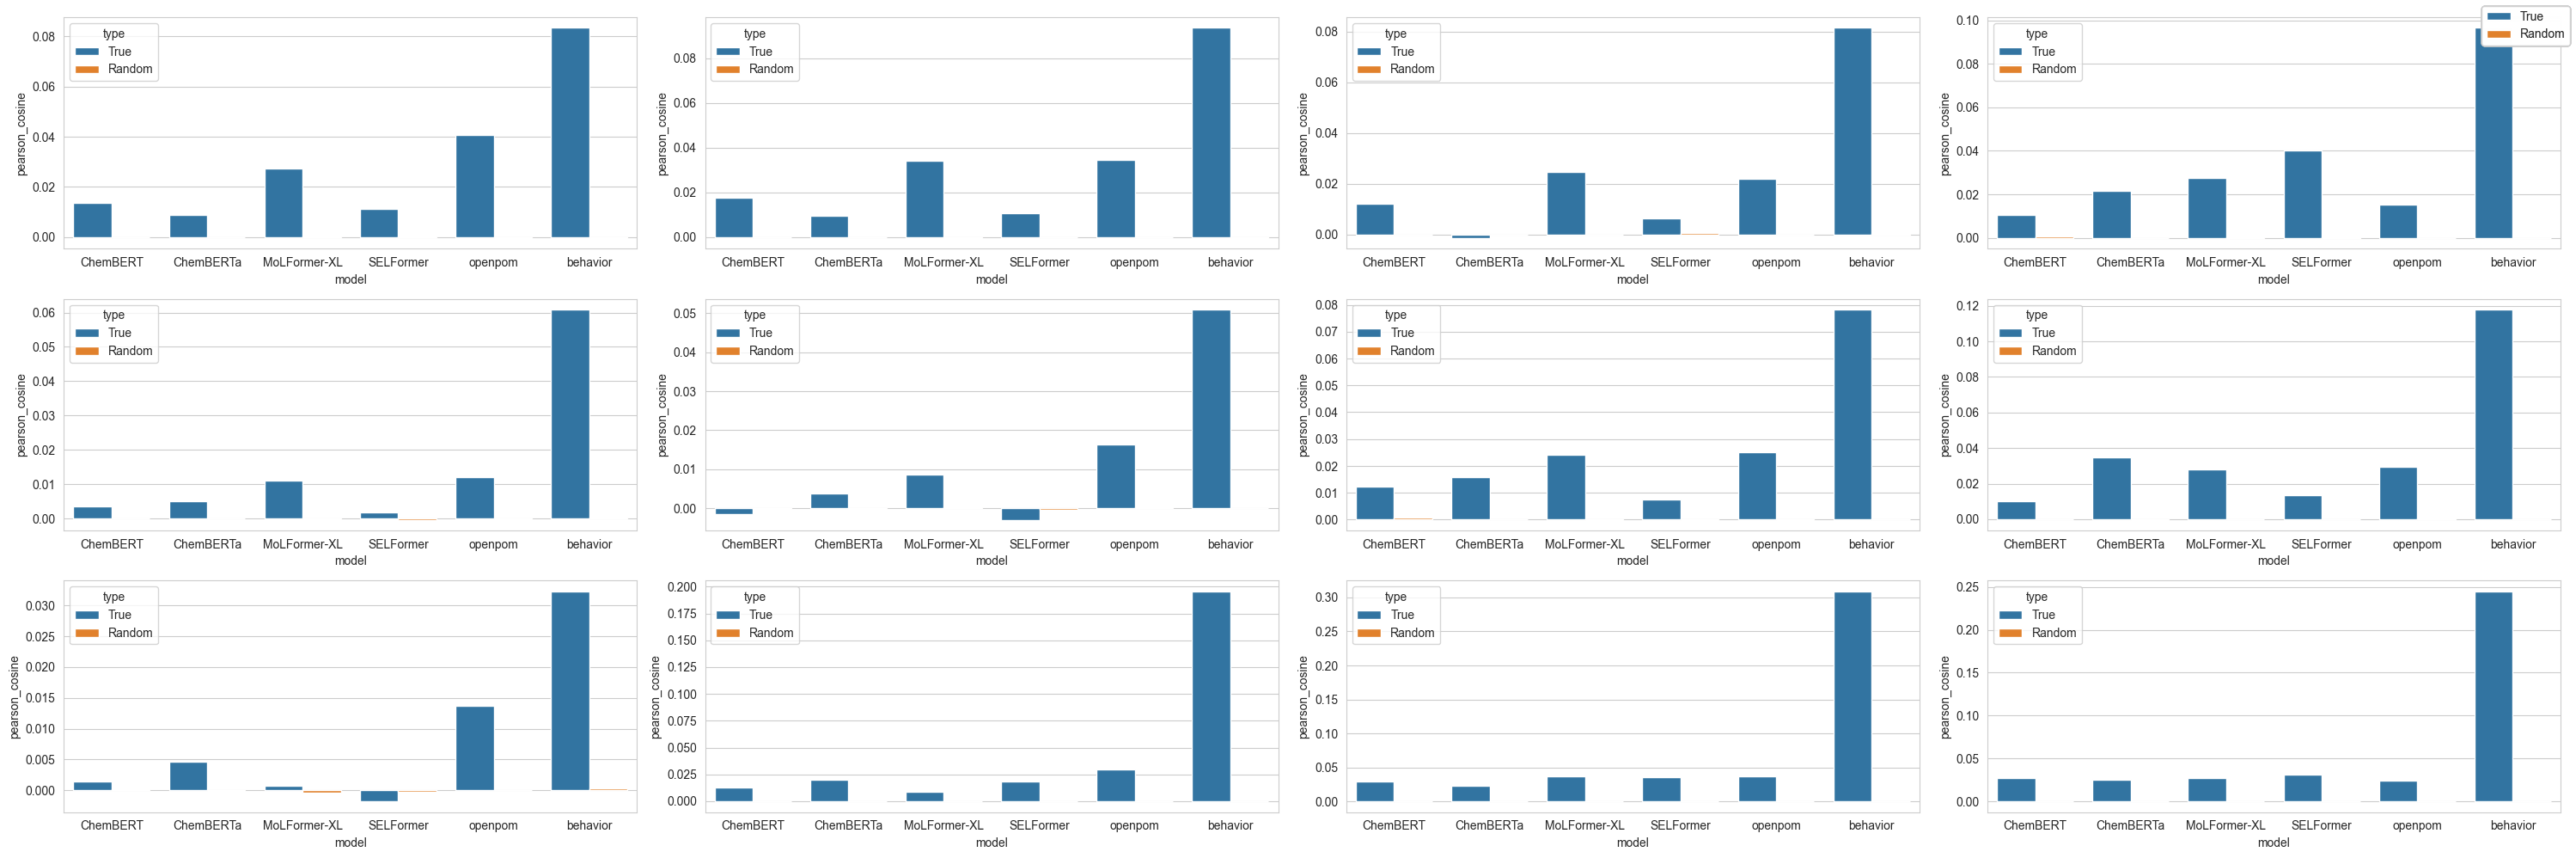

In [9]:
corrs_true = pd.read_csv(f'{save_path}/allVoxels_RSA.csv')

corrs_true.replace('ChemBERT_ChEMBL_pretrained', 'ChemBERT', inplace=True)
corrs_true.replace('ChemBERTa-zinc-base-v1', 'ChemBERTa', inplace=True)
corrs_true.replace('MoLFormer-XL-both-10pct', 'MoLFormer-XL', inplace=True)
fig,ax = plt.subplots(3,4,figsize=(30,10))
for s in range(1,4):
    metrics_subject = corrs_true[corrs_true['subject'] == s]
    # metrics_subject_random = metrics_significants_random[metrics_significants_random['subject'] == subject]
    # for i,roi in enumerate(['PirF']):
    for i,roi in enumerate(['PirF','PirT','AMY','OFC']):
        print(s,i)
        metrics_roi = metrics_subject[ metrics_subject['roi']==roi]
        sns.barplot(data=metrics_roi, x="model", y="spearman_cosine", hue="type",ax=ax[s-1,i])
        # ax[subject-1,i].set_title(f"Subject {subject} {roi}")

        handles, labels = ax[0,0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        plt.tight_layout()
plt.savefig(f"{save_path}/{orgi_avg}_Spearman_AllVoxels_hist_RSA.pdf")
plt.show()

fig,ax = plt.subplots(3,4,figsize=(30,10))
for s in range(1,4):
    metrics_subject = corrs_true[corrs_true['subject'] == s]
    # metrics_subject_random = metrics_significants_random[metrics_significants_random['subject'] == subject]
    # for i,roi in enumerate(['PirF']):
    for i,roi in enumerate(['PirF','PirT','AMY','OFC']):
        print(s,i)
        metrics_roi = metrics_subject[ metrics_subject['roi']==roi]
        sns.barplot(data=metrics_roi, x="model", y="pearson_cosine", hue="type",ax=ax[s-1,i])
        # ax[subject-1,i].set_title(f"Subject {subject} {roi}")

        handles, labels = ax[0,0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        plt.tight_layout()
plt.savefig(f"{save_path}/{orgi_avg}_Pearson_AllVoxels_hist_RSA.pdf")
plt.show()


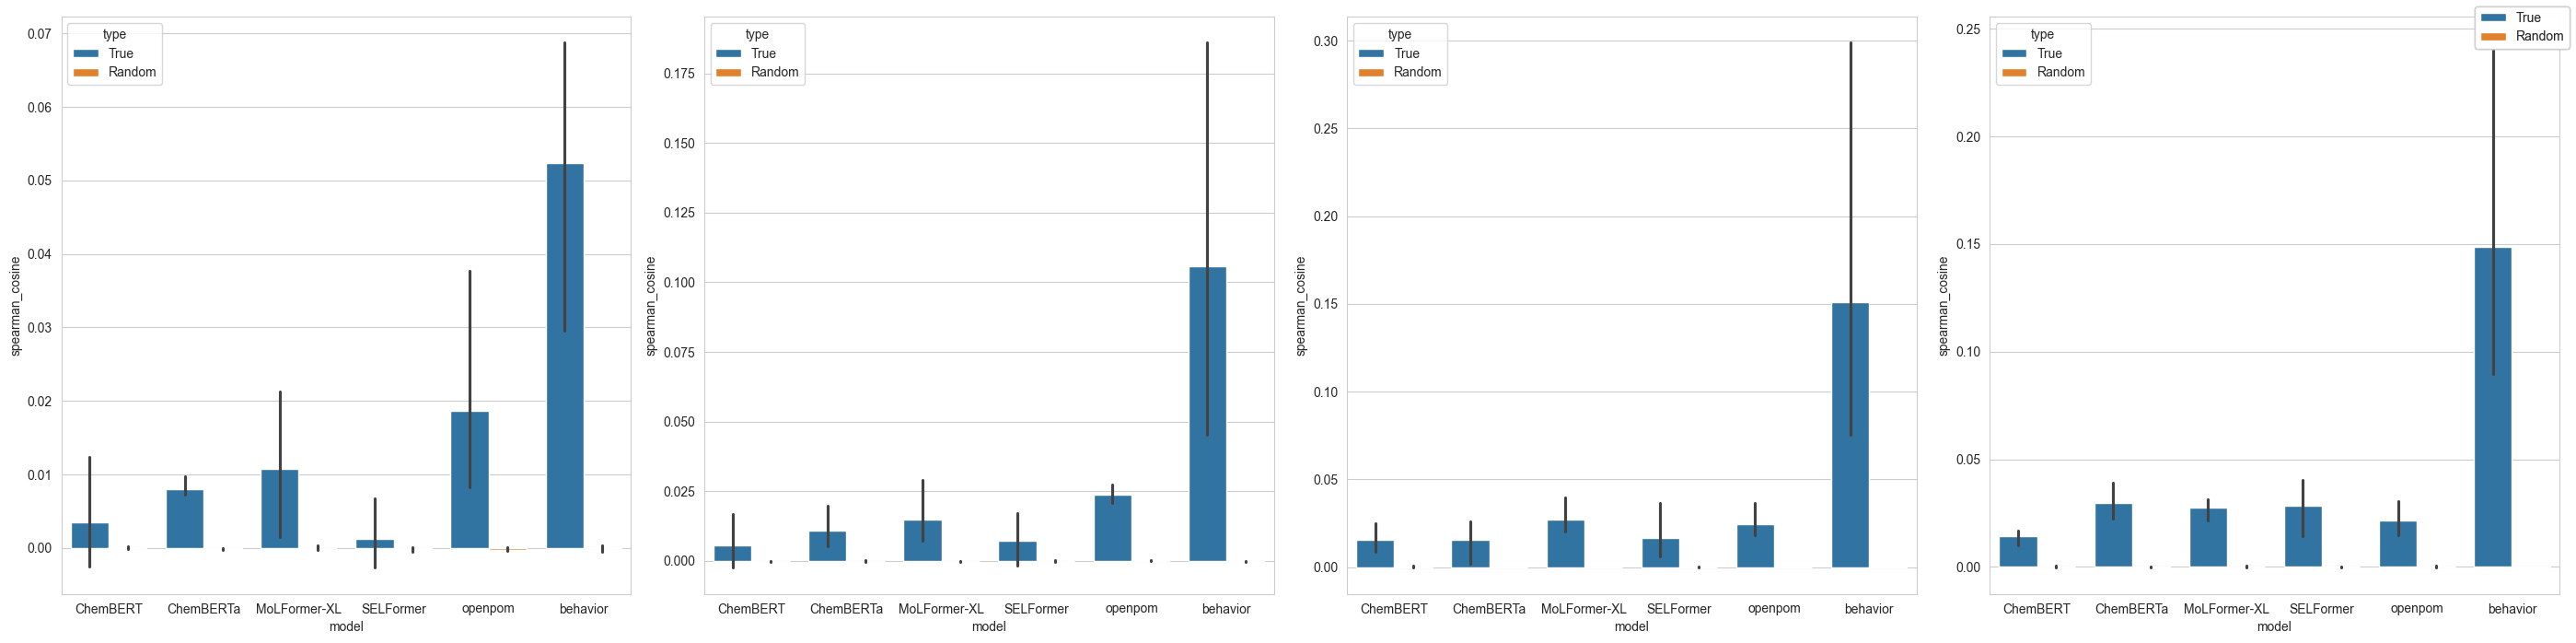

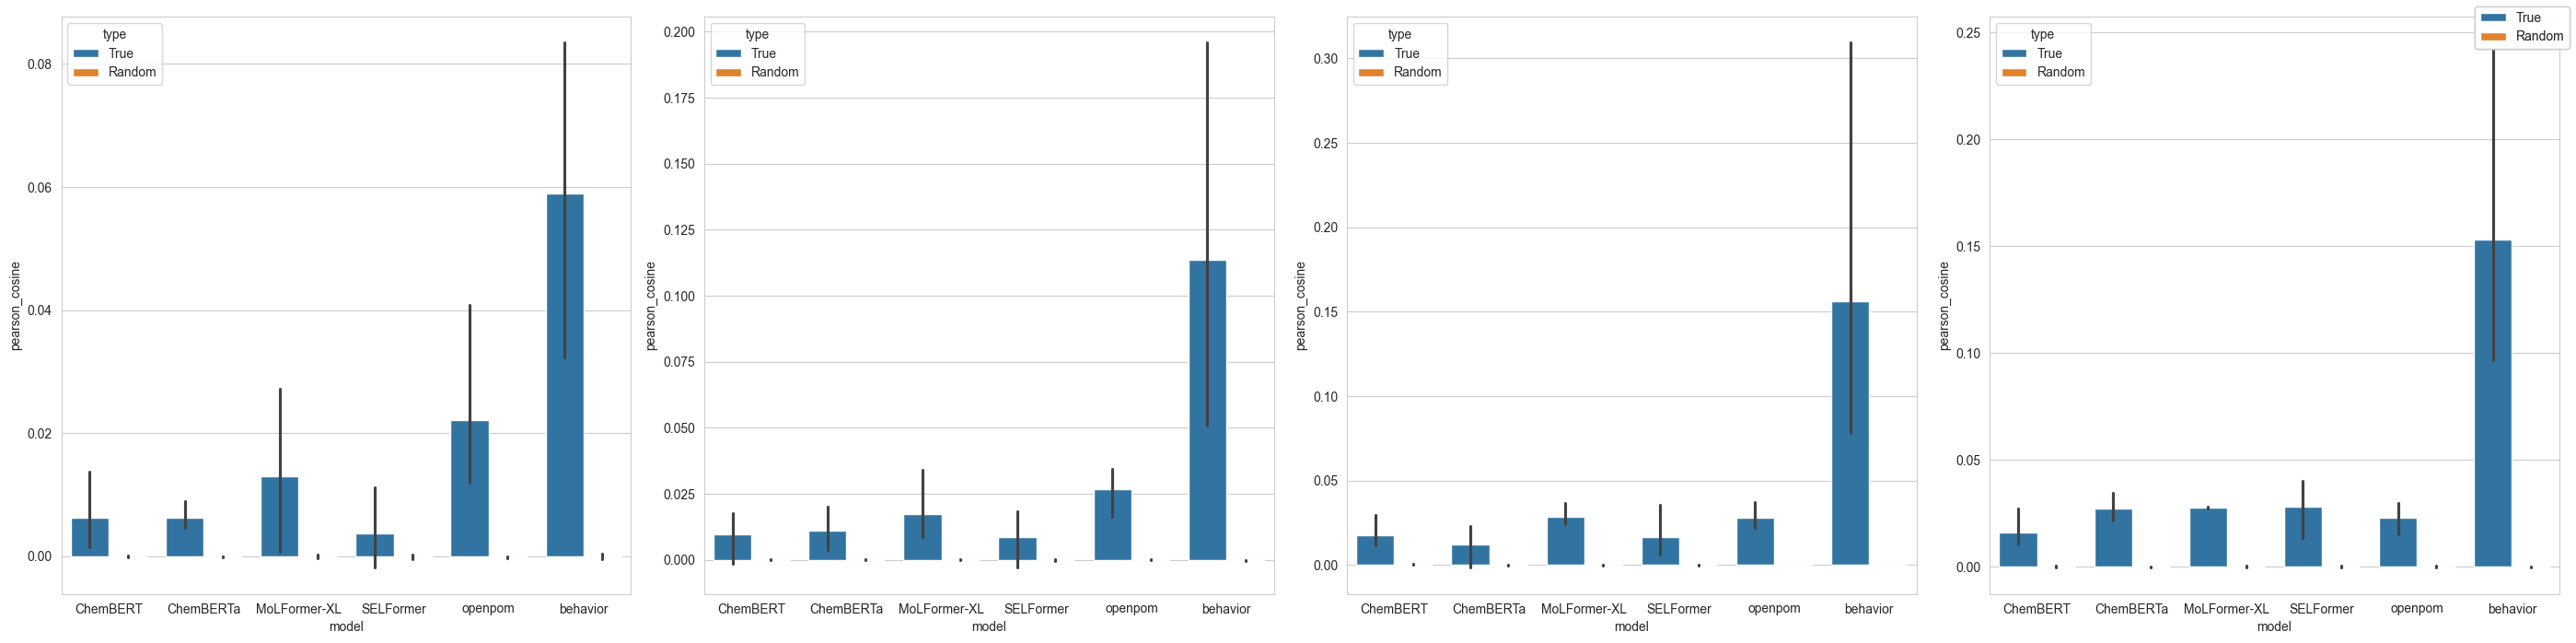

In [12]:
fig,ax = plt.subplots(1,4,figsize=(28,7))

# metrics_subject_random = metrics_significants_random[metrics_significants_random['subject'] == subject]
# for i,roi in enumerate(['PirF']):
for i,roi in enumerate(['PirF','PirT','AMY','OFC']):
    metrics_roi = corrs_true[ corrs_true['roi']==roi]
    sns.barplot(data=metrics_roi, x="model", y="spearman_cosine", hue="type",ax=ax[i])
    # ax[subject-1,i].set_title(f"Subject {subject} {roi}")
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
plt.savefig(f"{save_path}/{orgi_avg}_Spearman_AllVoxels_hist_RSA_Avg.pdf")
plt.show()

fig,ax = plt.subplots(1,4,figsize=(28,7))

# metrics_subject_random = metrics_significants_random[metrics_significants_random['subject'] == subject]
# for i,roi in enumerate(['PirF']):
for i,roi in enumerate(['PirF','PirT','AMY','OFC']):
    metrics_roi = corrs_true[ corrs_true['roi']==roi]
    sns.barplot(data=metrics_roi, x="model", y="pearson_cosine", hue="type",ax=ax[i])
    # ax[subject-1,i].set_title(f"Subject {subject} {roi}")

    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
plt.savefig(f"{save_path}/{orgi_avg}_Pearson_AllVoxels_hist_RSA_Avg.pdf")
plt.show()